In [1]:
import sys
import pandas as pd
from pathlib import Path
import numpy as np
import shutil
import matplotlib.pyplot as plt

from pyswmm import Simulation, Nodes, Output, SimulationPreConfig, Subcatchments
from swmm.toolkit import shared_enum



sys.path.append(r'C:\Users\everett\Documents\GitHub\camus_to')

repo_path = Path(r"C:\Users\everett\Documents\GitHub")  # Replace with the actual path to the optswmm repository
sys.path.append(str(repo_path))

from camus_to.src.performance import Performance


data_file = r"C:\Users\everett\Documents\GitHub\camus_to\data\clean\camus_to.nc"

from swmmio import Model

In [2]:
from optswmm.utils.runutils import summarize_runs
model_name = "HY052"
run_folder = Path(rf"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\{model_name}\runs")
subfolders = [f.name for f in run_folder.iterdir() if f.is_dir()]

tag = "higher-res"
runs = summarize_runs(run_folder).sort_values(by="dates")

WindowsPath('C:/Users/everett/Documents/GitHub/camus_to/data/models/swmm/HY052/runs/run-semidistr-1yr-v9_16-04-25-115849')

In [ ]:
from optswmm.utils.runutils import OptRun

run = OptRun(runs.index[0])



,iter,obj_param,node,fun,score
datetime,,,,,
16/04/25 11:58:51,0,('discharge(cms)','HY052'),nse,0.019284
16/04/25 11:58:52,1,('discharge(cms)','HY052'),nse,0.157614
16/04/25 11:58:54,2,('discharge(cms)','HY052'),nse,-0.129027
16/04/25 11:58:55,3,('discharge(cms)','HY052'),nse,0.163910
16/04/25 11:58:57,4,('discharge(cms)','HY052'),nse,0.163560
...,...,...,...,...,...
16/04/25 12:01:53,121,('discharge(cms)','HY052'),nse,0.443601
16/04/25 12:01:55,122,('discharge(cms)','HY052'),nse,0.443712
16/04/25 12:01:56,123,('discharge(cms)','HY052'),nse,0.443591


In [4]:
import plotly.graph_objs as go

for run_dir in runs.index:
    scores_file = run_dir / "results_scores.txt"
    scores_df = pd.read_csv(scores_file, sep=",", header=0, index_col=0).rename(columns=lambda x: x.strip())
    trace = go.Scatter(x=scores_df["iter"], y=scores_df["score"], mode='lines', name=run_dir.name)
    if 'fig' not in locals():
        fig = go.Figure()
    fig.add_trace(trace)

fig.update_layout(
    title="Run Scores",
    xaxis_title="Iteration",
    yaxis_title="Score",
    yaxis=dict(range=[0, 1]),
    legend_title="Run"
)
fig.show()

Mean Squared Error: 21452.89253678296


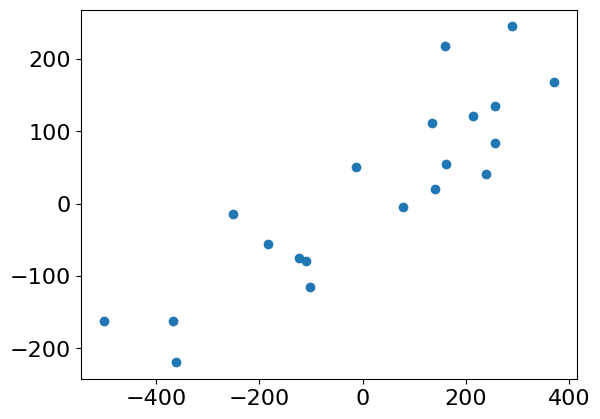

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Generate example data
X, y = make_regression(n_samples=100, n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Create and train the random forest model





rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

plt.scatter(y_test, y_pred)

In [ ]:
from utils.calparams import get_simpreconfig_at_iter
from utils.optconfig import OptConfig
from utils.swmmutils import set_model_datetimes

model_names =  [f.stem for f in Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm").iterdir()]
results = {key: {} for key in model_names}

tag = "v33"

for model_name in [["HY017"]]:#model_names:

    run_folder = Path(rf"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\{model_name}\runs")
    
    if not run_folder.exists():
        print(f"Run folder {run_folder} does not exist.")
        continue

    subfolders = [f.name for f in run_folder.iterdir() if f.is_dir()]

    runs = summarize_runs(run_folder).sort_values(by="dates")
    runs = runs[(runs["dates"] > pd.to_datetime("2025-04-16")).values]

    runs = runs[[tag in name for name in runs["name"]]]

    if len(runs) == 0:
        #print(f"No runs found for {model_name} with tag {tag}.")
        continue
    run_dir = runs.index[np.argmax(runs["best_score"])]
    #run_dir = runs.index[-1]

    param_file = run_dir / "results_params.txt"
    if not param_file.exists():
        print(f"Parameter file {param_file} does not exist.")
        continue
    params_df = pd.read_csv(param_file, sep=",", index_col=0)  # Adjust the separator if 
    if params_df.empty:
        print(f"Parameter file {param_file} is empty.")
        continue
    

    model_file = run_dir.parent.parent / f"{run_dir.parent.parent.stem}_cal.inp"
    oc = OptConfig(config_file=run_dir / "config.yml", model_file=Path(model_file))

    spc = get_simpreconfig_at_iter(run_dir=run_dir, iter=None)


    model = set_model_datetimes(
        model=Model(str(model_file)),
        start_datetime=oc.validation_start_date,
        end_datetime=oc.validation_end_date)
    model_file_eval = model_file.with_stem(model_file.stem + "_eval")

    model.inp.save(str(model_file_eval))

    outputfile = str(run_dir  / "eval.rpt")
    with Simulation(str(model_file_eval), outputfile=outputfile, sim_preconfig=spc) as sim:
        sim.execute()


    cal_targets = pd.read_pickle(run_dir.parent.parent / "targets.pkl")
    station_ids = np.unique(cal_targets.columns.get_level_values(1))
    params = np.unique(cal_targets.columns.get_level_values(0))
    params = [p for p in params if p in oc.target_variables]

    obs = cal_targets.loc[:, params]

    dfs = []
    with Output(outputfile) as out:
        for station_id in station_ids:
            for param in params:  
                if param in ["discharge(cms)","flow(cms)"]:
                    res = out.node_series(station_id, shared_enum.NodeAttribute.TOTAL_INFLOW)
                elif param in ["stage(m)","wl(m)"]:
                    res = out.node_series(station_id, shared_enum.NodeAttribute.INVERT_DEPTH)
                else:
                    raise ValueError(f"Parameter {param} not recognized")
                dfs.append(pd.DataFrame(index=res.keys(), data=res.values(), columns=pd.MultiIndex.from_tuples([(param, station_id)])).copy())

        sim = pd.concat(dfs, axis=1)
        sim.columns = pd.MultiIndex.from_tuples(sim.columns).copy()
        sim.index = sim.index.round('T')

    obs, sim = obs.align(sim, join='inner', axis=0)

    obs.to_pickle(run_dir.parent.parent / "obs_val.pkl")
    sim.to_pickle(run_dir.parent.parent / "sim_val.pkl")

    perf = Performance(obs=obs, sim=sim, high_flow_percentile=0.99)


    for param in ["kge","nse","false_negative_rate","true_negative_rate","mse", "rmse", "mae", "pve", "mse_hf"]:
        out = getattr(perf, param)()
        results[model_name][param] = out


#results_df = pd.DataFrame.from_dict(results, orient='index')
#results_df.to_csv(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\custom_train_perf.csv")
    #precip = pd.read_pickle(run_dir.parent.parent / model_name / "forcings.pkl")["precipitation(mm)"].tz_localize(None)

    #june_july_filter = (obs.index.month == 7) | (obs.index.month == 8)
    #june_july_filter = obs.loc["2008-07-01":"2008-08-31"].index

    #sim, precip = sim.align(precip, join='inner', axis=0)
    #output_path = Path(r"G:\My Drive\02_phd\00_conferences\2025-05 EGU\figs")
    #plot_hydrograph(obs, sim, precip, date_range=, output_path)
    

Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\custom_test_results\runs does not exist.
Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\custom_train_results\runs does not exist.
Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\custom_train_results\runs does not exist.
Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY005\runs does not exist.


c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY006_cal.rpt failed to initialize
cannot access local variable 'simulation_start' where it is not associated with a value
HY006_cal.rpt failed to initialize
negative seek position -500
HY006_cal.rpt failed to initialize
negative seek position -500
HY006_cal.rpt failed to initialize
negative seek position -500
HY006_cal.rpt failed to initialize
negative seek position -500
HY006_cal.rpt failed to initialize
negative seek position -500
HY006_cal.rpt failed to initialize
negative seek position -500
HY006_cal.rpt failed to initialize
negative seek position -500
HY006_cal.rpt failed to initialize
cannot access local variable 'simulation_start' where it is not associated with a value

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY010_cal.rpt failed to initialize
negative seek position -168
HY010_cal.rpt failed to initialize
negative seek position -500
HY010_cal.rpt failed to initialize
negative seek position -500
HY010_cal.rpt failed to initialize
negative seek position -500
HY010_cal.rpt failed to initialize
negative seek position -500
HY010_cal.rpt failed to initialize
negative seek position -500
HY010_cal.rpt failed to initialize
negative seek position -500
HY010_cal.rpt failed to initialize
negative seek position -500
HY010_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY013_cal.rpt failed to initialize
negative seek position -119
HY013_cal.rpt failed to initialize
negative seek position -500
HY013_cal.rpt failed to initialize
negative seek position -500
HY013_cal.rpt failed to initialize
negative seek position -500
HY013_cal.rpt failed to initialize
negative seek position -500
HY013_cal.rpt failed to initialize
negative seek position -500
HY013_cal.rpt failed to initialize
negative seek position -500
HY013_cal.rpt failed to initialize
negative seek position -500
HY013_cal.rpt failed to initialize
negative seek position -119

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')


Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY014\runs does not exist.


c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY017_cal.rpt failed to initialize
cannot access local variable 'simulation_start' where it is not associated with a value
HY017_cal.rpt failed to initialize
negative seek position -500
HY017_cal.rpt failed to initialize
negative seek position -500
HY017_cal.rpt failed to initialize
negative seek position -500
HY017_cal.rpt failed to initialize
negative seek position -500
HY017_cal.rpt failed to initialize
negative seek position -500
HY017_cal.rpt failed to initialize
negative seek position -500
HY017_cal.rpt failed to initialize
negative seek position -500
HY017_cal.rpt failed to initialize
cannot access local variable 'simulation_start' where it is not associated with a value

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY018_cal.rpt failed to initialize
cannot access local variable 'simulation_start' where it is not associated with a value
HY018_cal.rpt failed to initialize
negative seek position -500
HY018_cal.rpt failed to initialize
negative seek position -500
HY018_cal.rpt failed to initialize
negative seek position -500
HY018_cal.rpt failed to initialize
negative seek position -500
HY018_cal.rpt failed to initialize
negative seek position -500
HY018_cal.rpt failed to initialize
negative seek position -500
HY018_cal.rpt failed to initialize
negative seek position -500
HY018_cal.rpt failed to initialize
cannot access local variable 'simulation_start' where it is not associated with a value

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')


Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY019\runs does not exist.
Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY022\runs does not exist.


c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY023_cal.rpt failed to initialize
negative seek position -69
HY023_cal.rpt failed to initialize
negative seek position -500
HY023_cal.rpt failed to initialize
negative seek position -500
HY023_cal.rpt failed to initialize
negative seek position -500
HY023_cal.rpt failed to initialize
negative seek position -500
HY023_cal.rpt failed to initialize
negative seek position -500
HY023_cal.rpt failed to initialize
negative seek position -500
HY023_cal.rpt failed to initialize
negative seek position -500
HY023_cal.rpt failed to initialize
negative seek position -69

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY024_cal.rpt failed to initialize
negative seek position -119
HY024_cal.rpt failed to initialize
negative seek position -500
HY024_cal.rpt failed to initialize
negative seek position -500
HY024_cal.rpt failed to initialize
negative seek position -500
HY024_cal.rpt failed to initialize
negative seek position -500
HY024_cal.rpt failed to initialize
negative seek position -500
HY024_cal.rpt failed to initialize
negative seek position -500
HY024_cal.rpt failed to initialize
negative seek position -500
HY024_cal.rpt failed to initialize
negative seek position -118

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY026\runs does not exist.
Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY027\runs does not exist.
HY028_cal.rpt failed to initialize
negative seek position -119
HY028_cal.rpt failed to initialize
negative seek position -500
HY028_cal.rpt failed to initialize
negative seek position -500
HY028_cal.rpt failed to initialize
negative seek position -500
HY028_cal.rpt failed to initialize
negative seek position -500
HY028_cal.rpt failed to initialize
negative seek position -500
HY028_cal.rpt failed to initialize
negative seek position -500
HY028_cal.rpt failed to initialize
negative seek position -500
HY028_cal.rpt failed to initialize
negative seek position -119

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY034_cal.rpt failed to initialize
negative seek position -119
HY034_cal.rpt failed to initialize
negative seek position -500
HY034_cal.rpt failed to initialize
negative seek position -500
HY034_cal.rpt failed to initialize
negative seek position -500
HY034_cal.rpt failed to initialize
negative seek position -500
HY034_cal.rpt failed to initialize
negative seek position -500
HY034_cal.rpt failed to initialize
negative seek position -500
HY034_cal.rpt failed to initialize
negative seek position -500
HY034_cal.rpt failed to initialize
negative seek position -119

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY035_cal.rpt failed to initialize
negative seek position -168
HY035_cal.rpt failed to initialize
negative seek position -500
HY035_cal.rpt failed to initialize
negative seek position -500
HY035_cal.rpt failed to initialize
negative seek position -500
HY035_cal.rpt failed to initialize
negative seek position -500
HY035_cal.rpt failed to initialize
negative seek position -500
HY035_cal.rpt failed to initialize
negative seek position -500
HY035_cal.rpt failed to initialize
negative seek position -500
HY035_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY040_cal.rpt failed to initialize
negative seek position -168
HY040_cal.rpt failed to initialize
negative seek position -500
HY040_cal.rpt failed to initialize
negative seek position -500
HY040_cal.rpt failed to initialize
negative seek position -500
HY040_cal.rpt failed to initialize
negative seek position -500
HY040_cal.rpt failed to initialize
negative seek position -500
HY040_cal.rpt failed to initialize
negative seek position -500
HY040_cal.rpt failed to initialize
negative seek position -500
HY040_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY044\runs does not exist.
HY045_cal.rpt failed to initialize
negative seek position -118
HY045_cal.rpt failed to initialize
negative seek position -500
HY045_cal.rpt failed to initialize
negative seek position -500
HY045_cal.rpt failed to initialize
negative seek position -500
HY045_cal.rpt failed to initialize
negative seek position -500
HY045_cal.rpt failed to initialize
negative seek position -500
HY045_cal.rpt failed to initialize
negative seek position -500
HY045_cal.rpt failed to initialize
negative seek position -500
HY045_cal.rpt failed to initialize
negative seek position -118

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY051_cal.rpt failed to initialize
negative seek position -168
HY051_cal.rpt failed to initialize
negative seek position -500
HY051_cal.rpt failed to initialize
negative seek position -500
HY051_cal.rpt failed to initialize
negative seek position -500
HY051_cal.rpt failed to initialize
negative seek position -500
HY051_cal.rpt failed to initialize
negative seek position -500
HY051_cal.rpt failed to initialize
negative seek position -500
HY051_cal.rpt failed to initialize
negative seek position -500
HY051_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY052_cal.rpt failed to initialize
negative seek position -168
HY052_cal.rpt failed to initialize
negative seek position -500
HY052_cal.rpt failed to initialize
negative seek position -500
HY052_cal.rpt failed to initialize
negative seek position -500
HY052_cal.rpt failed to initialize
negative seek position -500
HY052_cal.rpt failed to initialize
negative seek position -500
HY052_cal.rpt failed to initialize
negative seek position -500
HY052_cal.rpt failed to initialize
negative seek position -500
HY052_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY053_cal.rpt failed to initialize
negative seek position -118
HY053_cal.rpt failed to initialize
negative seek position -500
HY053_cal.rpt failed to initialize
negative seek position -500
HY053_cal.rpt failed to initialize
negative seek position -500
HY053_cal.rpt failed to initialize
negative seek position -500
HY053_cal.rpt failed to initialize
negative seek position -500
HY053_cal.rpt failed to initialize
negative seek position -500
HY053_cal.rpt failed to initialize
negative seek position -500
HY053_cal.rpt failed to initialize
negative seek position -118

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY054_cal.rpt failed to initialize
negative seek position -168
HY054_cal.rpt failed to initialize
negative seek position -500
HY054_cal.rpt failed to initialize
negative seek position -500
HY054_cal.rpt failed to initialize
negative seek position -500
HY054_cal.rpt failed to initialize
negative seek position -500
HY054_cal.rpt failed to initialize
negative seek position -500
HY054_cal.rpt failed to initialize
negative seek position -500
HY054_cal.rpt failed to initialize
negative seek position -500
HY054_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY059_cal.rpt failed to initialize
negative seek position -118
HY059_cal.rpt failed to initialize
negative seek position -500
HY059_cal.rpt failed to initialize
negative seek position -500
HY059_cal.rpt failed to initialize
negative seek position -500
HY059_cal.rpt failed to initialize
negative seek position -500
HY059_cal.rpt failed to initialize
negative seek position -500
HY059_cal.rpt failed to initialize
negative seek position -500
HY059_cal.rpt failed to initialize
negative seek position -500
HY059_cal.rpt failed to initialize
negative seek position -118

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY060\runs does not exist.
HY062_cal.rpt failed to initialize
negative seek position -118
HY062_cal.rpt failed to initialize
negative seek position -500
HY062_cal.rpt failed to initialize
negative seek position -500
HY062_cal.rpt failed to initialize
negative seek position -500
HY062_cal.rpt failed to initialize
negative seek position -500
HY062_cal.rpt failed to initialize
negative seek position -500
HY062_cal.rpt failed to initialize
negative seek position -500
HY062_cal.rpt failed to initialize
negative seek position -500
HY062_cal.rpt failed to initialize
negative seek position -118

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY065_cal.rpt failed to initialize
negative seek position -168
HY065_cal.rpt failed to initialize
negative seek position -500
HY065_cal.rpt failed to initialize
negative seek position -500
HY065_cal.rpt failed to initialize
negative seek position -500
HY065_cal.rpt failed to initialize
negative seek position -500
HY065_cal.rpt failed to initialize
negative seek position -500
HY065_cal.rpt failed to initialize
negative seek position -500
HY065_cal.rpt failed to initialize
negative seek position -500
HY065_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY066_cal.rpt failed to initialize
negative seek position -118
HY066_cal.rpt failed to initialize
negative seek position -500
HY066_cal.rpt failed to initialize
negative seek position -500
HY066_cal.rpt failed to initialize
negative seek position -500
HY066_cal.rpt failed to initialize
negative seek position -500
HY066_cal.rpt failed to initialize
negative seek position -500
HY066_cal.rpt failed to initialize
negative seek position -500
HY066_cal.rpt failed to initialize
negative seek position -500
HY066_cal.rpt failed to initialize
negative seek position -118

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY067\runs does not exist.
Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY068\runs does not exist.
Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY079\runs does not exist.
Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY080\runs does not exist.
HY081_cal.rpt failed to initialize
negative seek position -168
HY081_cal.rpt failed to initialize
negative seek position -500
HY081_cal.rpt failed to initialize
negative seek position -500
HY081_cal.rpt failed to initialize
negative seek position -500
HY081_cal.rpt failed to initialize
negative seek position -500
HY081_cal.rpt failed to initialize
negative seek position -500
HY081_cal.rpt failed to initialize
negative seek position -500
HY081_cal.rpt failed to initialize
negative seek position -500
HY081_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY082_cal.rpt failed to initialize
negative seek position -118
HY082_cal.rpt failed to initialize
negative seek position -500
HY082_cal.rpt failed to initialize
negative seek position -500
HY082_cal.rpt failed to initialize
negative seek position -500
HY082_cal.rpt failed to initialize
negative seek position -500
HY082_cal.rpt failed to initialize
negative seek position -500
HY082_cal.rpt failed to initialize
negative seek position -500
HY082_cal.rpt failed to initialize
negative seek position -500
HY082_cal.rpt failed to initialize
negative seek position -118

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY084_cal.rpt failed to initialize
negative seek position -168
HY084_cal.rpt failed to initialize
negative seek position -500
HY084_cal.rpt failed to initialize
negative seek position -500
HY084_cal.rpt failed to initialize
negative seek position -500
HY084_cal.rpt failed to initialize
negative seek position -500
HY084_cal.rpt failed to initialize
negative seek position -500
HY084_cal.rpt failed to initialize
negative seek position -500
HY084_cal.rpt failed to initialize
negative seek position -500
HY084_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY091_cal.rpt failed to initialize
cannot access local variable 'simulation_start' where it is not associated with a value
HY091_cal.rpt failed to initialize
negative seek position -500
HY091_cal.rpt failed to initialize
negative seek position -500
HY091_cal.rpt failed to initialize
negative seek position -500
HY091_cal.rpt failed to initialize
negative seek position -500
HY091_cal.rpt failed to initialize
negative seek position -500
HY091_cal.rpt failed to initialize
negative seek position -500
HY091_cal.rpt failed to initialize
negative seek position -500
HY091_cal.rpt failed to initialize
cannot access local variable 'simulation_start' where it is not associated with a value

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY092_cal.rpt failed to initialize
negative seek position -119
HY092_cal.rpt failed to initialize
negative seek position -500
HY092_cal.rpt failed to initialize
negative seek position -500
HY092_cal.rpt failed to initialize
negative seek position -500
HY092_cal.rpt failed to initialize
negative seek position -500
HY092_cal.rpt failed to initialize
negative seek position -500
HY092_cal.rpt failed to initialize
negative seek position -500
HY092_cal.rpt failed to initialize
negative seek position -500
HY092_cal.rpt failed to initialize
negative seek position -119

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY093_cal.rpt failed to initialize
negative seek position -168
HY093_cal.rpt failed to initialize
negative seek position -500
HY093_cal.rpt failed to initialize
negative seek position -500
HY093_cal.rpt failed to initialize
negative seek position -500
HY093_cal.rpt failed to initialize
negative seek position -500
HY093_cal.rpt failed to initialize
negative seek position -500
HY093_cal.rpt failed to initialize
negative seek position -500
HY093_cal.rpt failed to initialize
negative seek position -500
HY093_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY095_cal.rpt failed to initialize
negative seek position -69
HY095_cal.rpt failed to initialize
negative seek position -500
HY095_cal.rpt failed to initialize
negative seek position -500
HY095_cal.rpt failed to initialize
negative seek position -500
HY095_cal.rpt failed to initialize
negative seek position -500
HY095_cal.rpt failed to initialize
negative seek position -500
HY095_cal.rpt failed to initialize
negative seek position -500
HY095_cal.rpt failed to initialize
negative seek position -500
HY095_cal.rpt failed to initialize
negative seek position -69

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY097_cal.rpt failed to initialize
cannot access local variable 'simulation_start' where it is not associated with a value
HY097_cal.rpt failed to initialize
negative seek position -500
HY097_cal.rpt failed to initialize
negative seek position -500
HY097_cal.rpt failed to initialize
negative seek position -500
HY097_cal.rpt failed to initialize
negative seek position -500
HY097_cal.rpt failed to initialize
negative seek position -500
HY097_cal.rpt failed to initialize
negative seek position -500
HY097_cal.rpt failed to initialize
negative seek position -500
HY097_cal.rpt failed to initialize
cannot access local variable 'simulation_start' where it is not associated with a value

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY098_cal.rpt failed to initialize
negative seek position -168
HY098_cal.rpt failed to initialize
negative seek position -500
HY098_cal.rpt failed to initialize
negative seek position -500
HY098_cal.rpt failed to initialize
negative seek position -500
HY098_cal.rpt failed to initialize
negative seek position -500
HY098_cal.rpt failed to initialize
negative seek position -500
HY098_cal.rpt failed to initialize
negative seek position -500
HY098_cal.rpt failed to initialize
negative seek position -500
HY098_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY100_cal.rpt failed to initialize
cannot access local variable 'simulation_start' where it is not associated with a value
HY100_cal.rpt failed to initialize
negative seek position -500
HY100_cal.rpt failed to initialize
negative seek position -500
HY100_cal.rpt failed to initialize
negative seek position -500
HY100_cal.rpt failed to initialize
negative seek position -500
HY100_cal.rpt failed to initialize
negative seek position -500
HY100_cal.rpt failed to initialize
negative seek position -500
HY100_cal.rpt failed to initialize
negative seek position -500
HY100_cal.rpt failed to initialize
cannot access local variable 'simulation_start' where it is not associated with a value

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY101_cal.rpt failed to initialize
negative seek position -118
HY101_cal.rpt failed to initialize
negative seek position -500
HY101_cal.rpt failed to initialize
negative seek position -500
HY101_cal.rpt failed to initialize
negative seek position -500
HY101_cal.rpt failed to initialize
negative seek position -500
HY101_cal.rpt failed to initialize
negative seek position -500
HY101_cal.rpt failed to initialize
negative seek position -500
HY101_cal.rpt failed to initialize
negative seek position -500
HY101_cal.rpt failed to initialize
negative seek position -118

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY103\runs does not exist.
Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY104\runs does not exist.
HY112_cal.rpt failed to initialize
negative seek position -118
HY112_cal.rpt failed to initialize
negative seek position -500
HY112_cal.rpt failed to initialize
negative seek position -500
HY112_cal.rpt failed to initialize
negative seek position -500
HY112_cal.rpt failed to initialize
negative seek position -500
HY112_cal.rpt failed to initialize
negative seek position -500
HY112_cal.rpt failed to initialize
negative seek position -500
HY112_cal.rpt failed to initialize
negative seek position -500
HY112_cal.rpt failed to initialize
negative seek position -118

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY116\runs does not exist.
HY118_cal.rpt failed to initialize
negative seek position -168
HY118_cal.rpt failed to initialize
negative seek position -500
HY118_cal.rpt failed to initialize
negative seek position -500
HY118_cal.rpt failed to initialize
negative seek position -500
HY118_cal.rpt failed to initialize
negative seek position -500
HY118_cal.rpt failed to initialize
negative seek position -500
HY118_cal.rpt failed to initialize
negative seek position -500
HY118_cal.rpt failed to initialize
negative seek position -500
HY118_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run Complete

C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')
c:\Users\everett\Documents\GitHub\optswmm\utils\calparams.py:617: UserWarning: iter not specified, using last iter
  warning("iter not specified, using last iter")


HY119_cal.rpt failed to initialize
negative seek position -168
HY119_cal.rpt failed to initialize
negative seek position -500
HY119_cal.rpt failed to initialize
negative seek position -500
HY119_cal.rpt failed to initialize
negative seek position -500
HY119_cal.rpt failed to initialize
negative seek position -500
HY119_cal.rpt failed to initialize
negative seek position -500
HY119_cal.rpt failed to initialize
negative seek position -500
HY119_cal.rpt failed to initialize
negative seek position -500
HY119_cal.rpt failed to initialize
negative seek position -168

... SWMM Version 5.2.4
... Run CompleteRun folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY120\runs does not exist.
Run folder C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY123\runs does not exist.


C:\Users\everett\AppData\Local\Temp\ipykernel_19560\1089472512.py:80: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sim.index = sim.index.round('T')


<Axes: title={'center': 'CDF of KGE'}, xlabel='Index', ylabel='KGE'>

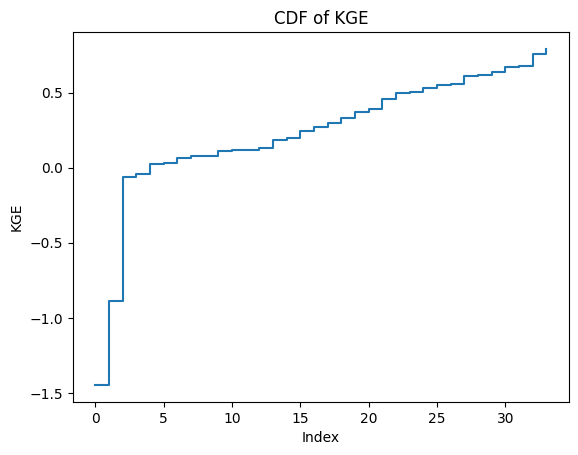

In [4]:
df = pd.DataFrame.from_dict(results).T
df.loc[:, "kge"].dropna().sort_values().reset_index(drop=True).plot(drawstyle="steps-post", title="CDF of KGE", xlabel="Index", ylabel="KGE")

In [ ]:
from matplotlib.dates import WeekdayLocator, DateFormatter
import matplotlib.pyplot as plt
# Set font size globally
plt.rcParams.update({'font.size': 16})


def plot_hydrograph(catchment, obs, sim, precip, date_range=None, format="wide"):

    # Filter data for June and July

    #june_july_filter = obs.index
    # Plot filtered data

    for formats in ["wide","narrow","full"]:
        if formats == "wide":
            figsize = (29, 6)
        elif formats == "narrow":
            figsize = (14.5, 12)
        elif formats == "full":
            figsize = (29, 12)
        else:
            raise ValueError("formats must be 'wide', 'narrow', or 'full'")
        fig, ax = plt.subplots(figsize=figsize)

        ax.plot(obs.loc[june_july_filter].index, obs.loc[june_july_filter, "discharge(cms)"], label="obs", color="black", linestyle="-", linewidth=4)
        ax.plot(sim.loc[june_july_filter].index, sim.loc[june_july_filter, "discharge(cms)"], label="sim", color="red", linestyle="-", linewidth=2)

        ax2 = ax.twinx()

        ax2.plot(precip.loc[june_july_filter].index, precip.loc[june_july_filter].values, label="precipitation", color="#1f77b4", linestyle="-", linewidth=4, zorder=-1)

        ax2.set_ylabel("Precipitation (mm/hr)")
        ax2.set_ylim(0, 50)  # Set the range of the y-axis to 30
        ax2.invert_yaxis()  # Reverse the y-axis
        ax2.set_xticklabels([])
        

        perf = Performance(obs=obs.loc[june_july_filter], sim=sim.loc[june_july_filter], high_flow_percentile=0.99)

        plt.title(f"SWMM: catchment {catchment}: observed vs simulated hydrographs (KGE={perf.kge():.2f})", fontsize=20)
        plt.xlabel("Time")
        ax.set_ylabel("Discharge (cms)")

        plt.sca(ax)
        plt.legend(["Obs","Sim"], loc="center left", fontsize=14, frameon=False)

        # Set x-axis ticks to every week
        ax.xaxis.set_major_locator(WeekdayLocator())
        ax.xaxis.set_major_formatter(DateFormatter("%b %d"))
        # Set daily minor ticks
        ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=range(7), interval=1))
        # Set minor x-axis ticks

        ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=range(7), interval=1))

        ax.set_xlim([obs.loc[june_july_filter].index.min(), obs.loc[june_july_filter].index.max()])
        #ax.set_ylim(0,80)

        plt.grid(which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

        #output_path = Path(r"G:\My Drive\02_phd\00_conferences\2025-05 EGU\figs")
        #output_path.mkdir(parents=True, exist_ok=True)

        fig.savefig(output_path / f"swmm_{catchment}_hydrograph_{formats}.png", dpi=900, bbox_inches="tight")
        fig.clf()

for model_name in [["HY017"]]:#model_names:
    obs = pd.read_pickle(run_dir.parent.parent / "obs_val.pkl")
    sim = pd.read_pickle(run_dir.parent.parent / "sim_val.pkl")
    precip = pd.read_pickle(run_dir.parent.parent / "forcings.pkl")["precipitation(mm)"].tz_localize(None)
    
    


len(results)

In [ ]:
from datetime import datetime, timedelta
dry_step = pd.Timestamp("00:00:01")

datetime.strftime(dry_step, '%H:%M:%S')

'00:00:01'

In [8]:
results = {key: value for key, value in results.items() if value != {}}
len(results)

12

In [13]:
pd.DataFrame(results)

,custom_test_results,custom_train_results,...,HY120,HY123
kge,NaN,NaN,...,NaN,NaN
nse,NaN,NaN,...,NaN,NaN
false_negative_rate,NaN,NaN,...,NaN,NaN
true_negative_rate,NaN,NaN,...,NaN,NaN
mse,NaN,NaN,...,NaN,NaN
rmse,NaN,NaN,...,NaN,NaN
mae,NaN,NaN,...,NaN,NaN
pve,NaN,NaN,...,NaN,NaN
mse_hf,NaN,NaN,...,NaN,NaN


<Axes: xlabel='datetime'>

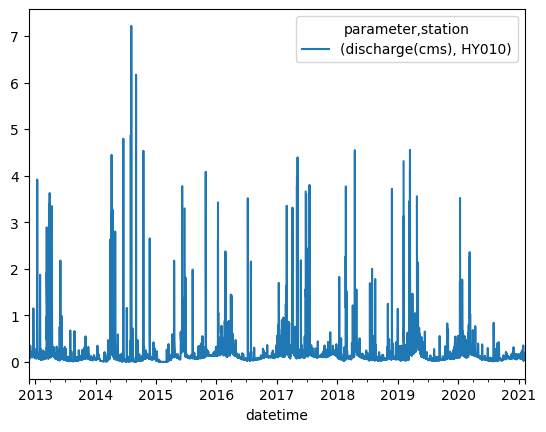

In [25]:
obs.plot()

Looks at model directory, runs all uncalibrated models and plots result versus target data

0.6367458913978427
0.6988197239638848
0.1829337899543379
1.0025685283798171


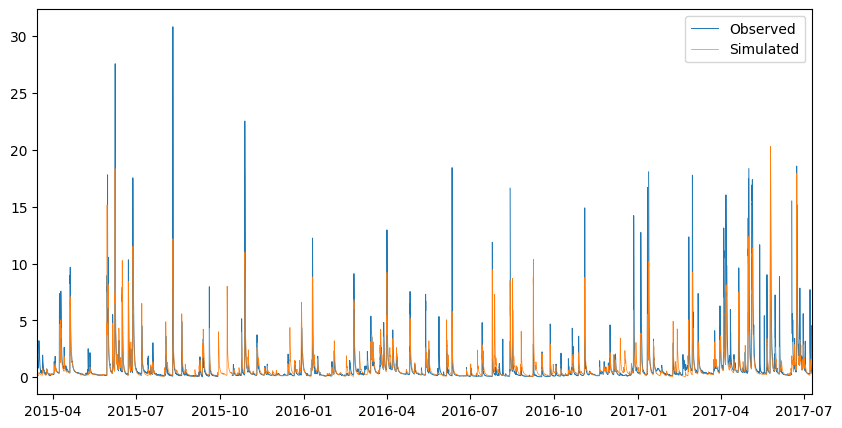

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))



ax.plot(obs, label="Observed", linewidth=0.7)
ax.plot(sim, linewidth=0.5, label="Simulated")
ax.set_xlim(sim.index.min(), sim.index.max())
ax.legend()




In [18]:
perf.kge()

array([0.63674589])

In [3]:



cal_targets = pd.read_pickle(run_dir.parent / "forcings.pkl")
station_ids = np.unique(cal_targets.columns.get_level_values(1))
params = np.unique(cal_targets.columns.get_level_values(0))


    params = [p for p in params if p in opt_config.target_variables]
    if len(params) == 0:
        raise ValueError(f"No parameters to evaluate; target_variables: {opt_config.target_variables}, target_data: {cal_targets.columns.get_level_values(0)}")
    
    obs = cal_targets.loc[:, params]

    scores = pd.DataFrame(index=station_ids, columns=params)
    dfs = []

    with Output(outputfile) as out:
        for station_id in station_ids:
            for param in params:  
                if param in ["discharge(cms)","flow(cms)"]:
                    res = out.node_series(station_id, shared_enum.NodeAttribute.TOTAL_INFLOW)
                elif param in ["stage(m)","wl(m)"]:
                    res = out.node_series(station_id, shared_enum.NodeAttribute.INVERT_DEPTH)
                else:
                    raise ValueError(f"Parameter {param} not recognized")
                dfs.append(pd.DataFrame(index=res.keys(), data=res.values(), columns=pd.MultiIndex.from_tuples([(param, station_id)])).copy())

    df = pd.concat(dfs, axis=1)
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    sim = df.copy()

    
    sim, obs = sync_timeseries(sim, obs)
    #sim = get_predictions_at_nodes(model=Model(cal_model_tmp), nodes=eval_nodes, param="FLOW_RATE")
    #sim = get_node_timeseries(model=Model(cal_model_tmp),nodes=eval_nodes, params=["TOTAL_INFLOW"])["TOTAL_INFLOW"][eval_nodes]
    #sim = sim.resample('15min').mean()

    if opt_config.normalize:
        scaler = get_scaler(obs)
        scaler = [s.values for s in scaler]
        obs = normalise(obs, scaler)
        sim = normalise(sim, scaler)

    #obs = obs.iloc[opt_config["warmup_length"]:, :]
    #sim = sim.iloc[opt_config["warmup_length"]:, :]

    score = [score_fun(obs.loc[:, col], sim.loc[:, col]) for col in obs.columns]

    scores = pd.DataFrame(index=obs.columns, data=score, columns=[score_function])


    if opt_config.normalize:
        obs = denormalise(obs, scaler)
        sim = denormalise(sim, scaler)

    

        #timeseries_results["hrt"].update({col: {"obs": obs.loc[:, col], "sim": sim.loc[:, col]} for col in obs.columns})


    # invert sign of NSE since opt function will always minimize
    if score_function in MAXIMIZE_FUNCTIONS:
        scores = scores.apply(lambda x: -x)

    return scores, {"obs": obs, "sim": sim}

IndentationError: unexpected indent (2305513207.py, line 6)

In [265]:
model_name = "HY006"
run_folder = Path(rf"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\{model_name}\runs")
subfolders = [f.name for f in run_folder.iterdir() if f.is_dir()]



run_dir = run_folder / subfolders[-1]
scores_file = run_dir / "results_scores.txt"
scores_df = pd.read_csv(scores_file, sep=",", header=0)  # Adjust the separator if necessary

param_file = run_dir / "results_params.txt"
params_df = pd.read_csv(param_file, sep=",")  # Adjust the separator if necessary

import matplotlib.pyplot as plt

ax = scores_df["score"].plot()


TypeError: no numeric data to plot

TypeError: no numeric data to plot

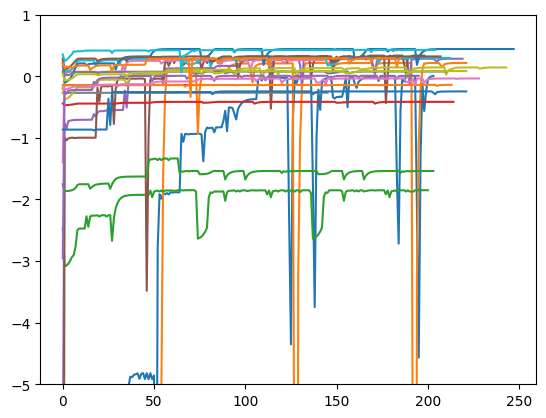

In [ ]:
import pandas as pd

for model_dir in Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm").iterdir():

    run_folder = Path(rf"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\{model_dir.stem}\runs")
    subfolders = [f.name for f in run_folder.iterdir() if f.is_dir()]

    run_dir = run_folder / subfolders[-1]
    scores_file = run_dir / "results_scores.txt"
    scores_df = pd.read_csv(scores_file, sep=",", header=0)  # Adjust the separator if necessary

    param_file = run_dir / "results_params.txt"
    params_df = pd.read_csv(param_file, sep=",")  # Adjust the separator if necessary

    import matplotlib.pyplot as plt

    ax = scores_df["score"].plot()
    ax.set_ylim(-5, 1)

In [81]:

targets_df = pd.read_pickle(model_dir / "HY006" / "targets.pkl")
targets_df.index = targets_df.index.tz_localize(None)
targets_df

,stage(m),discharge(cms)
station,HY006,HY006
time,,
2015-01-01 00:15:00,0.288,0.375809
2015-01-01 00:30:00,0.292,0.373330
2015-01-01 00:45:00,0.293,0.368400
2015-01-01 01:00:00,0.294,0.363498
2015-01-01 01:15:00,0.290,0.358622
...,...,...
2021-02-03 12:45:00,0.226,0.241614
2021-02-03 13:00:00,0.229,0.247658


In [312]:
run_dir

WindowsPath('C:/Users/everett/Documents/GitHub/camus_to/data/models/swmm/HY017/runs/run-semidist-1yr-v3_13-04-25-150706')

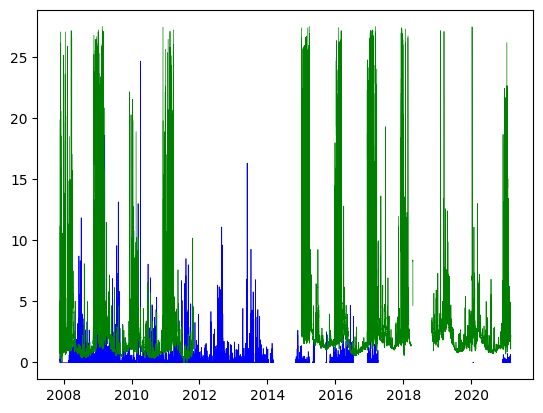

In [324]:
precip = pd.read_pickle(model_dir / "HY006" / "forcings.pkl")["precipitation(mm)"].tz_localize(None)

obs = pd.read_pickle(model_dir / "HY006" / "targets.pkl")["discharge(cms)"].tz_localize(None)

plt.plot(precip.index, precip.values, label="Observed Precipitation", color="blue", linewidth=0.5)
plt.plot(obs.index, obs.values, label="Observed Discharge", color="green", linewidth=0.5)

In [157]:
sim

,discharge(cms)
,HY006
2007-11-22 09:00:00,0.028678
2007-11-22 10:00:00,0.187606
2007-11-22 11:00:00,0.359035
2007-11-22 12:00:00,0.376486
2007-11-22 13:00:00,0.377163
...,...
2008-11-21 04:00:00,5.014121
2008-11-21 05:00:00,4.928904
2008-11-21 06:00:00,4.847275


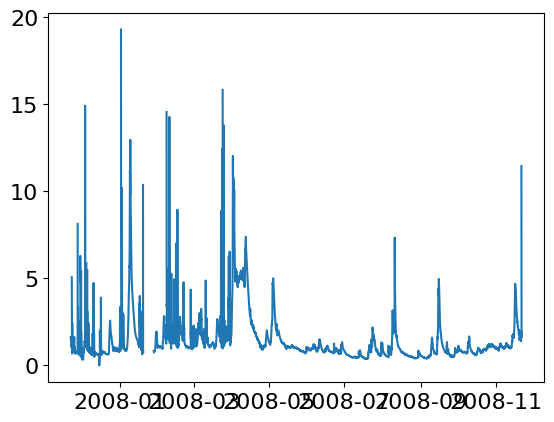

In [189]:
plt.plot(obs)

In [24]:
sim

,discharge(cms)
,HY035
2012-11-20 13:00:00,0.011405
2012-11-20 14:00:00,0.018124
2012-11-20 15:00:00,0.022579
2012-11-20 16:00:00,0.023644
2012-11-20 17:00:00,0.023853
...,...
2013-11-20 08:00:00,0.308834
2013-11-20 09:00:00,0.304949
2013-11-20 10:00:00,0.301154


In [94]:
obs

parameter,discharge(cms)
station,HY023
2012-11-22 12:00:00,0.658642
2012-11-22 13:00:00,0.658642
2012-11-22 14:00:00,0.658642
2012-11-22 15:00:00,0.658642
2012-11-22 16:00:00,0.667385
...,...
2013-11-22 07:00:00,0.818280
2013-11-22 08:00:00,0.853991
2013-11-22 09:00:00,0.878560


In [100]:
run_dir / "timeseries" / f"obs_{iter}.pkl"

WindowsPath('C:/Users/everett/Documents/GitHub/camus_to/data/models/swmm/HY006/runs/run-distr-1yr-v21_19-04-25-201558/timeseries/obs_70.pkl')

In [101]:
df = pd.read_pickle(run_dir / "timeseries" / f"obs_{iter}.pkl")
df

parameter,discharge(cms)
station,HY006
2007-11-22 09:00:00,1.626971
2007-11-22 10:00:00,1.602377
2007-11-22 11:00:00,1.613837
2007-11-22 12:00:00,1.586034
2007-11-22 13:00:00,1.556746
...,...
2008-11-21 04:00:00,NaN
2008-11-21 05:00:00,11.443881
2008-11-21 06:00:00,6.286268


C:\Users\everett\AppData\Local\Temp\ipykernel_16012\139475720.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  iter = int(runs.max_iter[-1] // 10 * 10)


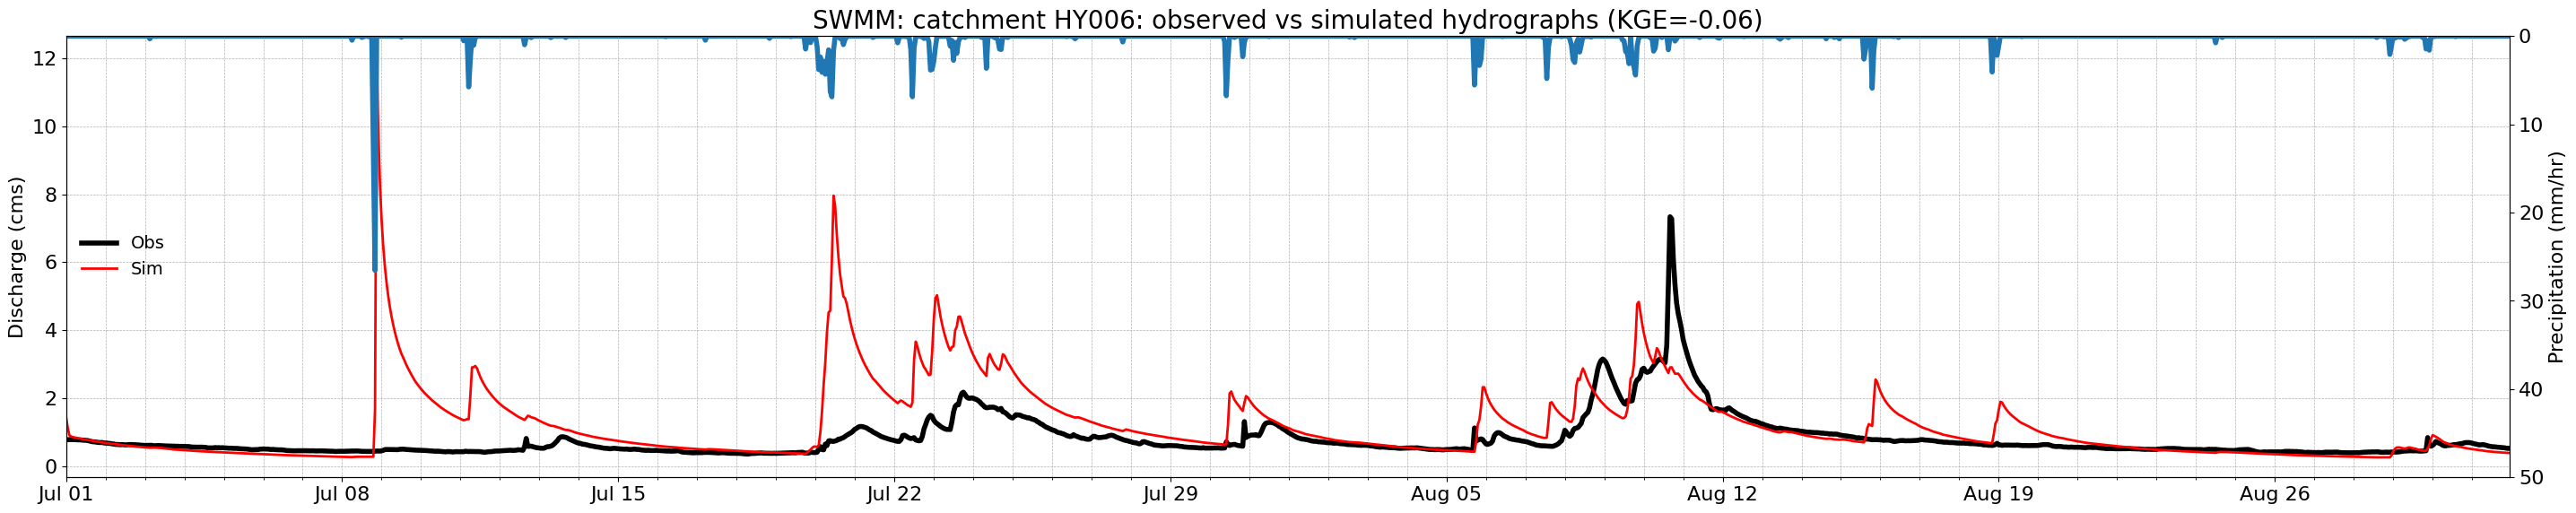

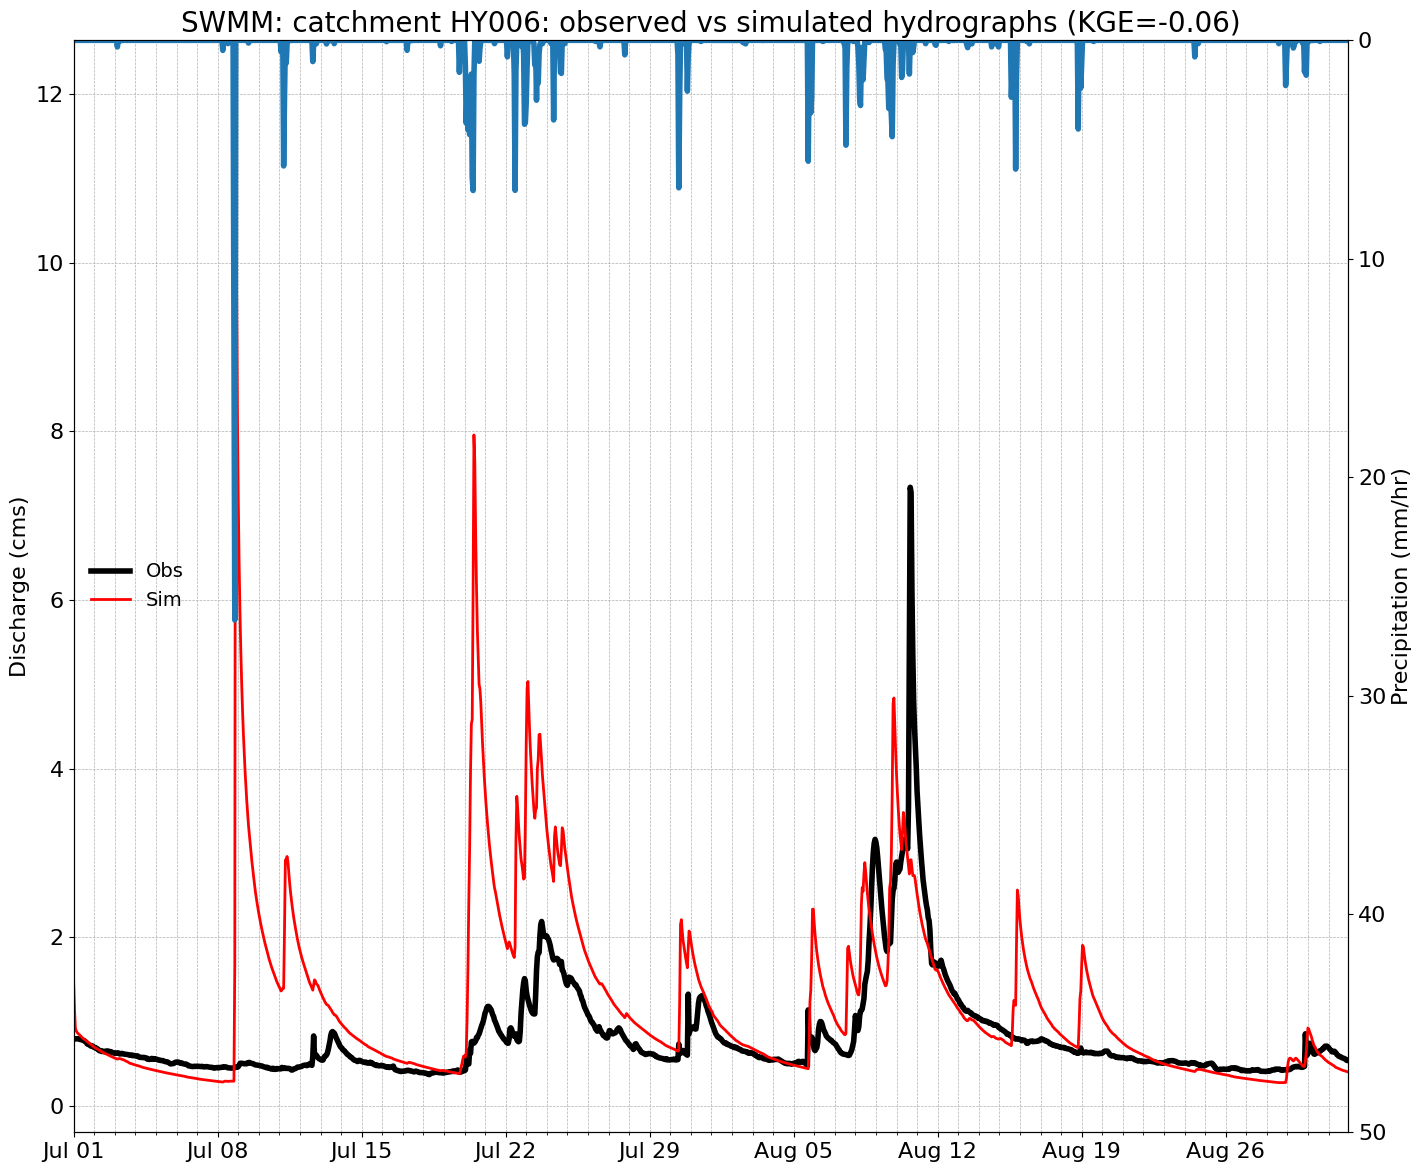

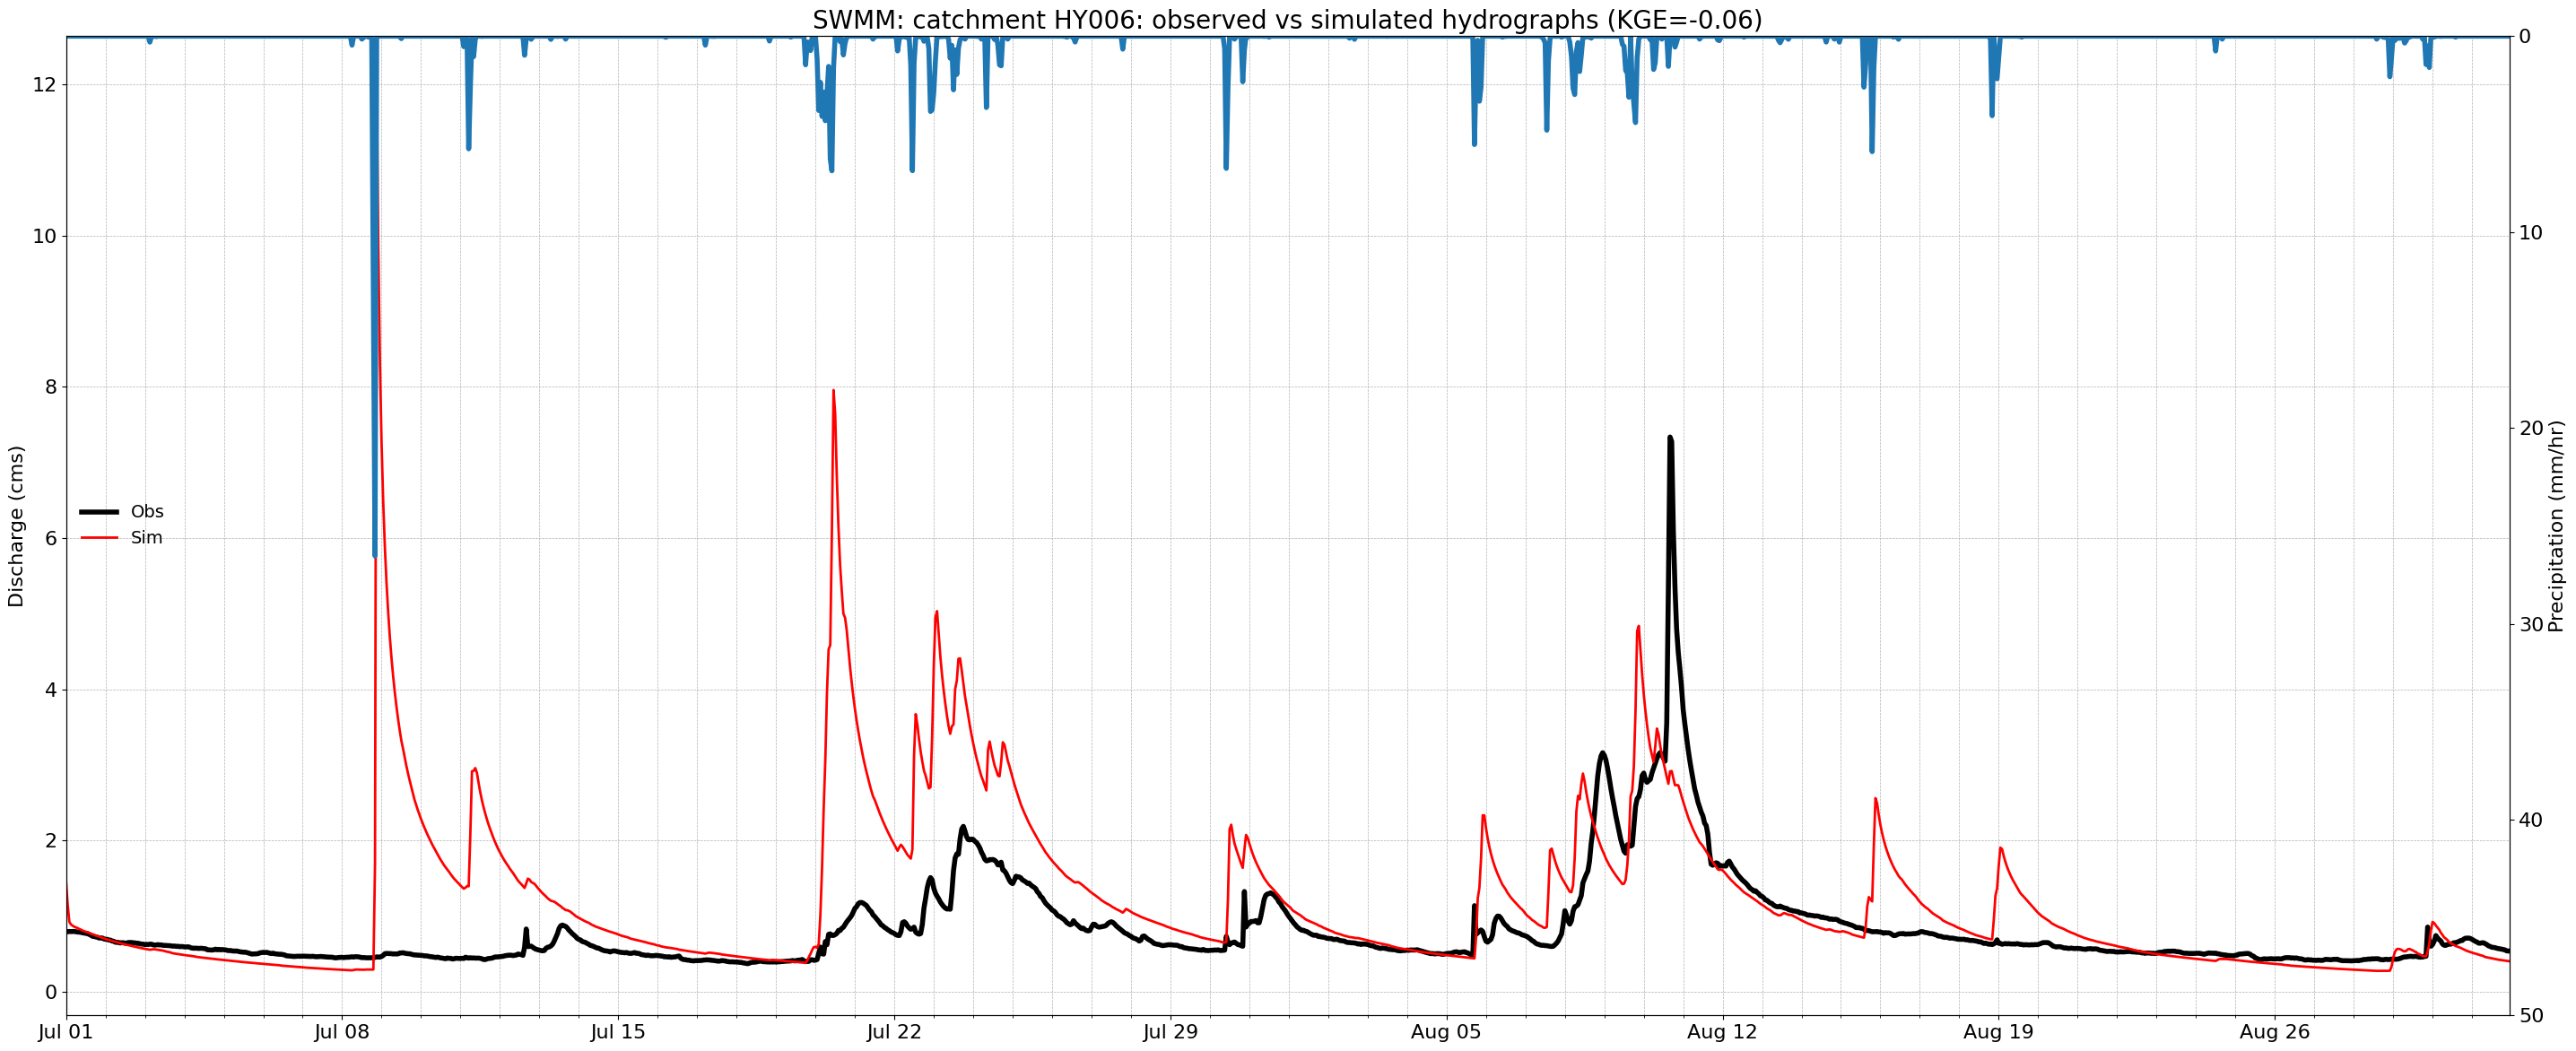

In [187]:
ax.get_xlim()

(np.float64(0.0), np.float64(1.0))

C:\Users\everett\AppData\Local\Temp\ipykernel_4556\3185233241.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', len(subdirs))
c:\Users\everett\Documents\GitHub\optswmm\.venv\Lib\site-packages\swmmio\utils\dataframes.py:135: UserWarning: VERTICES section not found in C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY005\HY005.inp
  warnings.warn(f'{sect} section not found in {inp_path}')
c:\Users\everett\Documents\GitHub\optswmm\.venv\Lib\site-packages\swmmio\utils\dataframes.py:135: UserWarning: VERTICES section not found in C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY006\HY006.inp
  warnings.warn(f'{sect} section not found in {inp_path}')
c:\Users\everett\Documents\GitHub\optswmm\.venv\Lib\site-packages\swmmio\utils\dataframes.py:135: UserWarning: 

{np.str_('HY104'):      Raingage   Outlet  ...  PctRouted  \
 Name                    ...              
 s0      HY104    node0  ...          0   
 s1      HY104    node1  ...          0   
 s2      HY104    node2  ...          0   
 s3      HY104    node3  ...          0   
 s4      HY104    node4  ...          0   
 ...       ...      ...  ...        ...   
 s472    HY104  node472  ...          0   
 s473    HY104  node473  ...          0   
 s474    HY104  node474  ...          0   
 s104    HY104    HY104  ...          0   
 s104    HY104    HY104  ...          0   
 
                                                                                                                                                                                                      geometry  
 Name                                                                                                                                                                                                           
 s0

In [ ]:
[n for key, n in nodes]

,InvertElev,MaxDepth,...,StageOrTimeseries,geometry
Name,,,,,
node0,299.1669,0.0,...,NaN,POINT (590400 4870800)
node1,292.6976,0.0,...,NaN,POINT (591900 4870000)
node2,308.4353,0.0,...,NaN,POINT (592600 4870500)
node3,278.9102,0.0,...,NaN,POINT (591400 4868600)
node4,416.0844,0.0,...,NaN,POINT (580700 4869800)
...,...,...,...,...,...
node108,269.7902,0.0,...,NaN,POINT (592800 4858100)
node109,291.5053,0.0,...,NaN,POINT (590600 4857700)
node110,288.6467,0.0,...,NaN,POINT (590900 4857600)


NameError: name 'gdf' is not defined

<Axes: >

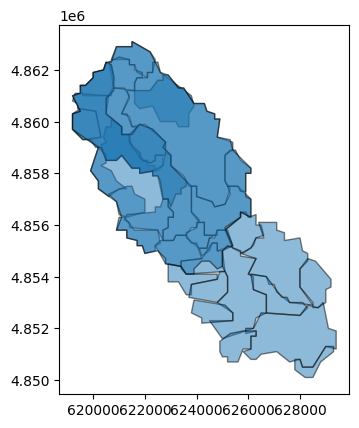

In [158]:
subcatchments[list(subcatchments.keys())[29]].plot(edgecolor="black", alpha=0.5)

In [ ]:
from utils.calparams import CalParam

cps = list()
cps.append(CalParam(section='infiltration', attribute='CurveNum', lower=1, upper=1, lower_bound=0, upper_bound=100, distributed=True))
cps.append(CalParam(section='subcatchments', attribute='Width', lower=0.5, upper=0.5, lower_bound=0.1, upper_bound=10**6, distributed=True))
#cps.append(CalParam(section='subcatchments', attribute='PercSlope', lower=1, upper=1, lower_bound=0, upper_bound=100, distributed=True))
cps.append(CalParam(section='subcatchments', attribute='Area', lower=1, upper=0, lower_bound=0, upper_bound=1E6, distributed=True))

from swmmio import Model
cps_distributed = []
for cp in cps:
    cps_distributed += cp.distribute(Model(str(model_file)))

# update the bounds relative to the initial values of each calibration parameter
cps_distributed = [cp.set_relative_bounds(upper=cp.upper, lower=cp.lower) for cp in cps_distributed]




HY035.rpt failed to initialize
negative seek position -168
HY035.rpt failed to initialize
negative seek position -168
HY035.rpt failed to initialize
negative seek position -168


In [4]:
with Simulation(str(model_file), outputfile="test.out") as sim:
    S1 = Subcatchments(sim)["s1"]
    print(S1.area)
    sim.execute()

from pyswmm import Output
from swmm.toolkit import shared_enum

with Output("test.out") as out:
    ok = out.node_series("HY035", shared_enum.NodeAttribute.TOTAL_INFLOW)


print(ok)
shared_enum.NodeAttribute.TOTAL_INFLOW


1529.0

... SWMM Version 5.2.4
... Run Complete{datetime.datetime(2016, 2, 1, 0, 0): 0.06890132278203964}


<NodeAttribute.TOTAL_INFLOW: 4>

HY035.rpt failed to initialize
negative seek position -168


In [ ]:
with Simulation(str(model_file), outputfile="test.out") as sim:
    S1 = Subcatchments(sim)["s1"]
    print(S1)
    print(infiltration_params)

TypeError: 'PySWMM' object is not callable

In [ ]:
import os
spc = SimulationPreConfig()
spc.input_file = str(model_file)
spc.add_update_by_token("SUBCATCHMENTS", "s1", 3, 1321321000000)
spc.add_update_by_token("SUBCATCHMENTS", "s2", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s3", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s4", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s5", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s7", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s8", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s9", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s10", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s11", 3, 1321312000000)
spc.apply_changes()

with Simulation(str(model_file), sim_preconfig=spc, outputfile="test.out") as sim:
    S1 = Subcatchments(sim)["s1"]
    print(S1.area)
    sim.execute()

from pyswmm import Output
from swmm.toolkit import shared_enum

with Output("test.out") as out:
    ok = out.node_series("HY035", shared_enum.NodeAttribute.TOTAL_INFLOW)


print(ok)
shared_enum.NodeAttribute.TOTAL_INFLOW

from utils.swmmutils import get_model_path

os.remove("test.out")


1321321000000.0

... SWMM Version 5.2.4

KeyboardInterrupt: 

In [166]:
import pandas as pd
pd.DataFrame(index=ok.keys(), data=ok.values()).plot()

NameError: name 'ok' is not defined

In [ ]:
with Simulation(str(model_file), outputfile="test.out") as sim:
    subcatchment_ids = [s.subcatchmentid for s in Subcatchments(sim)]
    ok = Subcatchments(sim)["s1"].__getattribute__("width")

ok


AttributeError: 'Subcatchment' object has no attribute 's'

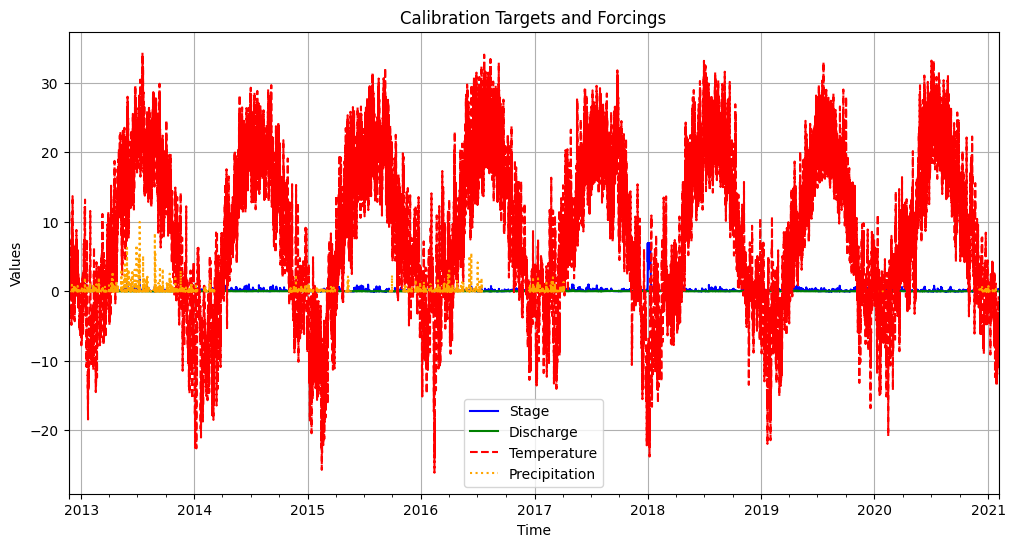

In [125]:
from utils.optconfig import OptConfig

oc = OptConfig(
    model_file = model_file,
    forcing_data_file = model_dir / station_id / "forcings.pkl",
    target_data_file = model_dir / station_id / "targets.pkl",
    run_folder = model_dir / station_id / "runs",
)

cal_targets = pd.read_pickle(oc.target_data_file)
cal_forcings = pd.read_pickle(oc.forcing_data_file)


fig, ax = plt.subplots(figsize=(12, 6))

# Plot cal_targets
cal_targets[("stage", station_id)].plot(ax=ax, label="Stage", color="blue")
cal_targets[("discharge", station_id)].plot(ax=ax, label="Discharge", color="green")

# Plot cal_forcings
cal_forcings[("temperature", station_id)].plot(ax=ax, label="Temperature", color="red", linestyle="--")
cal_forcings[("precipitation", station_id)].plot(ax=ax, label="Precipitation", color="orange", linestyle=":")

# Add labels, legend, and grid
ax.set_title("Calibration Targets and Forcings")
ax.set_xlabel("Time")
ax.set_ylabel("Values")
ax.legend()
ax.grid()
plt.show()


... SWMM Version 5.2.4
... Run Complete

In [ ]:
for ii in range(100):
    Output(str(model_file.with_suffix('.out'))).node_series("HY035", shared_enum.NodeAttribute.TOTAL_INFLOW)




... SWMM Version 5.2.4

Exception: 
  ERROR 307: cannot open binary results file.

<aenum 'NodeAttribute'>

AttributeError: 'WindowsPath' object has no attribute 'inp'

In [ ]:
nodes = ["node1","node2"]
res = {node:[] for node in nodes}
dti = []

PARAM_MAPPING = {"discharge":"total_inflow","stage":"depth"}

with Simulation(str(model_file)) as sim:
    for step in sim:
        dti.append(sim.current_time)
        for node in nodes:
            res[node].append(getattr(Nodes(sim)[node],PARAM_MAPPING["discharge"]))



In [ ]:
from utils.calibutils import _validate_target_data
import pandas as pd
from swmmio import Model
tgt = pd.read_pickle(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY035\targets.pkl")
mdl = Model(str(model_file))

_validate_target_data(tgt, mdl)



True

'C:\\Users\\everett\\Documents\\GitHub\\camus_to\\data\\models\\swmm\\HY035\\targets.pkl'

In [ ]:
from swmmio import Model
mdl = Model(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY095\HY095.inp")

from defs import SWMM_DATETIME_FMT


from utils.swmmutils import get_model_datetimes




In [ ]:
import pandas as pd
from pathlib import Path

tgt_stations = tgt.columns.get_level_values('station').unique().to_list()





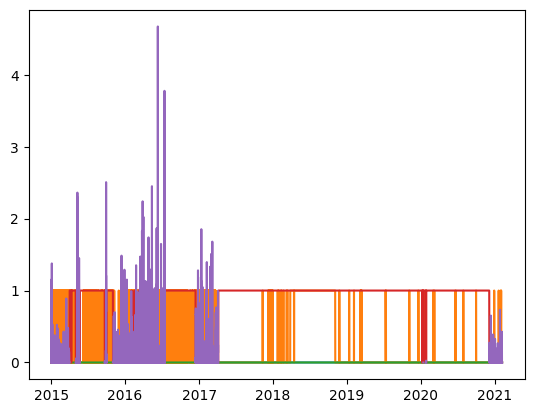

In [ ]:
plt.plot(df.isna())
plt.plot(df["precipitation"])

In [ ]:
import pandas as pd
df

,stage,discharge,temperature,precipitation
station,HY006,HY006,HY006,HY006
time,,,,
2015-01-01 00:15:00,0.252772,0.010861,-7.433333,0.000000
2015-01-01 00:30:00,0.254771,0.010996,-7.408333,0.000000
2015-01-01 00:45:00,0.256771,0.011030,-7.383333,0.000000
2015-01-01 01:00:00,0.259771,0.011064,-7.358333,0.000000
2015-01-01 01:15:00,0.261771,0.010928,-7.416667,0.095586
...,...,...,...,...
2021-02-05 18:00:00,0.275583,0.009178,-7.220000,0.000000
2021-02-05 18:15:00,0.275583,0.009114,-7.295000,0.000000
